In [1121]:
import pandas as pd
import numpy as np
import random
import json

In [1122]:
district_list = np.arange(1,12)
district_df = []

In [1123]:
guide_list = ['alice', 'guardian', 'league & broke', 'berniecrats', 'chronicle', 'examiner']

voter_guide_data = pd.DataFrame({
    'alice': {'sup_1': '0000180', 'sup_2': '0000179', 'sup_3': '0000000'},
    'guardian': {'sup_1': '0000181', 'sup_2': '0000180', 'sup_3': '0000000'},
    'league & broke': {'sup_1': '0000181', 'sup_2': '0000180', 'sup_3': '0000184'},
    'berniecrats': {'sup_1': '0000181', 'sup_2': '0000184', 'sup_3': '0000180'},
    'chronicle': {'sup_1': '0000179', 'sup_2': '0000000', 'sup_3': '0000000'},
    'examiner': {'sup_1': '0000180', 'sup_2': '0000000', 'sup_3': '0000000'}
}).T


In [1124]:

precinct_id_to_name = pd.read_csv('./precinct_id_to_name.txt', sep="\t")

t1 = precinct_id_to_name.loc[:, ['precinct_id', 'name']]
t1.rename(columns={'name': 'precinct_name'}, inplace=True)
t1.precinct_name = t1.precinct_name.str[4:]
t1.precinct_name = pd.to_numeric(t1.precinct_name)


In [1125]:
precinct_name_to_district = pd.read_csv('./precinct_name_to_district.txt', sep="\t")

t2 = precinct_name_to_district.loc[:, ['VotingPrecinctName', 'Supervisorial']]
t2.rename(columns={'VotingPrecinctName': 'precinct_name'}, inplace=True)
t2.precinct_name = t2.precinct_name.str[4:]
t2.precinct_name = pd.to_numeric(t2.precinct_name)

In [1126]:
precinct_id_to_district = pd.merge(t1, t2, on='precinct_name', how="inner")
precinct_id_to_district.set_index('precinct_id', inplace=True)
print(precinct_id_to_district)

             precinct_name  Supervisorial
precinct_id                              
1                     1101             11
2                     1102             11
3                     1103             11
4                     1104             11
4                     1105             11
5                     1106             11
6                     1107             11
7                     1108             11
8                     1109             11
9                     1111             11
10                    1112             11
11                    1113             11
12                    1114             11
13                    1115             11
14                    1116             11
15                    1117             11
16                    1118             11
17                    1119             11
18                    1121             11
19                    1122             11
20                    1123             11
21                    1124        

In [1127]:
data = pd.read_csv('./20180627_ballotimage.txt', sep=" ", header=None)
ballot = data.iloc[:, 0].astype(str)


In [1128]:
ballot_data = pd.DataFrame({
    'contest_id': ballot.str[0:7],
    'voter_number': ballot.str[7:16],
    'serial_number': ballot.str[16:23],
    'tally_type': ballot.str[23: 26],
    'precinct_id': ballot.str[26: 33],
    'rcv': ballot.str[33: 36],
    'candidate_number': ballot.str[36: 43],
    'over': ballot.str[43],
    'under': ballot.str[44]
})

ballot_data['precinct_id'] = pd.to_numeric(ballot_data['precinct_id'] )
print(ballot_data.head())


  contest_id voter_number serial_number tally_type  precinct_id  rcv  \
0    0000020    000012886       0000001        002            9  001   
1    0000020    000012886       0000001        002            9  002   
2    0000020    000012886       0000001        002            9  003   
3    0000020    000012887       0000001        002            9  001   
4    0000020    000012887       0000001        002            9  002   

  candidate_number over under  
0          0000181    0     0  
1          0000185    0     0  
2          0000180    0     0  
3          0000181    0     0  
4          0000183    0     0  


In [1129]:
ballot_data = pd.pivot_table(ballot_data, values='candidate_number', columns="rcv", index=["precinct_id", "serial_number"], aggfunc="first")

precinct_id_list = [x[0] for x in ballot_data.index.values]
precinct_id_list = set(precinct_id_list)


for x in precinct_id_list:
    ballot_data.loc[x, 'District'] = "d_" + str(precinct_id_to_district.iloc[x]['Supervisorial'])


In [1130]:
for x in district_list:
    t = ballot_data[ballot_data['District'] == "d_" + str(x)]
    district_df.append(t)

print(district_df[0])

rcv                            001      002      003 District
precinct_id serial_number                                    
97          0000004        0000179  0000183  0000182      d_1
            0000015        0000180  0000181  0000000      d_1
            0000018        0000180  0000181  0000183      d_1
            0000019        0000181  0000180  0000184      d_1
            0000031        0000179  0000180  0000000      d_1
            0000036        0000179  0000180  0000183      d_1
            0000038        0000000  0000181  0000179      d_1
            0000045        0000179  0000183  0000180      d_1
            0000051        0000179  0000183  0000185      d_1
            0000060        0000179  0000183  0000180      d_1
            0000065        0000179  0000180  0000000      d_1
            0000072        0000179  0000180  0000181      d_1
            0000084        0000180  0000179  0000181      d_1
            0000090        0000179  0000183  0000180      d_1
        

In [1131]:
col_list = []+ guide_list+ ['other', 'total_votes']

guide_tally = pd.DataFrame(columns=col_list)
guide_tally.index.name = 'District'

for d in district_df:
    district_name = d['District'][0]
    for index, row in voter_guide_data.iterrows():
        s = d[
          (d['001'] == row['sup_1']) & 
          ((d['002'] == row['sup_2']) | (row['sup_2'] == '0000000')) & 
          ((d['003'] == row['sup_3']) | (row['sup_3'] == '0000000'))]
        guide_tally.loc[district_name, row.name] = len(s.index)
    guide_tally.loc[district_name, 'other'] = guide_tally.loc[district_name].sum()
    guide_tally.loc[district_name, 'total_votes'] = len(d.index)
print(guide_tally)


          alice  guardian  league & broke  berniecrats  chronicle  examiner  \
District                                                                      
d_1        72.0     216.0            77.0          4.0      519.0     339.0   
d_2       101.0     170.0            50.0          4.0      864.0     442.0   
d_3        91.0     193.0            45.0          9.0      493.0     363.0   
d_4        66.0     184.0            53.0          1.0      502.0     261.0   
d_5       131.0     406.0           156.0         10.0      895.0     505.0   
d_6        95.0     158.0            49.0          6.0      555.0     382.0   
d_7       112.0     168.0            56.0          5.0      687.0     427.0   
d_8       243.0     377.0           149.0         12.0      767.0     861.0   
d_9        88.0     348.0           149.0          8.0      500.0     411.0   
d_10       59.0     143.0            42.0          3.0      768.0     272.0   
d_11       58.0     173.0            58.0          5

In [1132]:
for g in guide_list:
    guide_tally[g] = guide_tally[g] / guide_tally['total_votes']
guide_tally['other'] = guide_tally['other'] / guide_tally['total_votes']
print(guide_tally)    

             alice  guardian  league & broke  berniecrats  chronicle  \
District                                                               
d_1       0.043011  0.129032        0.045998     0.002389   0.310036   
d_2       0.047396  0.079775        0.023463     0.001877   0.405443   
d_3       0.056875  0.120625        0.028125     0.005625   0.308125   
d_4       0.040024  0.111583        0.032141     0.000606   0.304427   
d_5       0.053274  0.165108        0.063440     0.004067   0.363969   
d_6       0.056920  0.094667        0.029359     0.003595   0.332534   
d_7       0.057851  0.086777        0.028926     0.002583   0.354855   
d_8       0.095669  0.148425        0.058661     0.004724   0.301969   
d_9       0.048431  0.191524        0.082003     0.004403   0.275179   
d_10      0.034503  0.083626        0.024561     0.001754   0.449123   
d_11      0.038874  0.115952        0.038874     0.003351   0.308981   

          examiner     other  total_votes  
District           

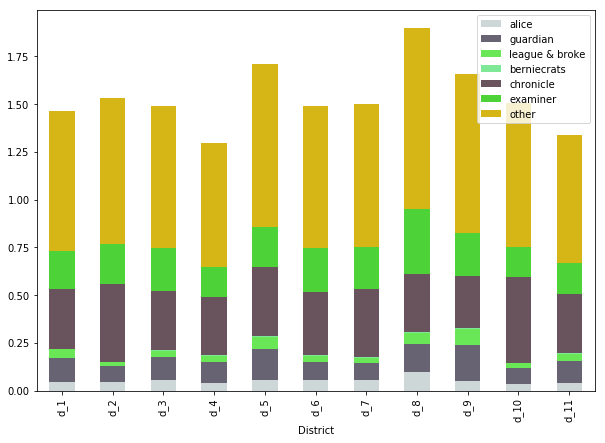

In [1137]:
def generate_color_code():
    random_number = random.randint(0,16777215)
    hex_number = str(hex(random_number))
    hex_number ='#'+ hex_number[2:]
    return hex_number

colors = [""] * 7

colors = list(map(lambda x: generate_color_code(), colors))
guide_tally.loc[:, "alice": "other"].plot.bar(stacked=True, color=colors, figsize=(10,7))